In [1]:
# Carnegie Mellon University city temp dataset
# https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488

In [2]:
from collections import defaultdict
from csv import DictReader
from datetime import datetime
from os.path import join
from pandas import to_datetime
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

In [3]:
directory = './cmu_dataset_7890488'
cities = {}
with open(join(directory, 'city_info.csv')) as fh:
    csv = DictReader(fh)
    for row in csv:
        cities[row['Stn.Name']] = row

In [4]:
#sorted(cities.keys())

In [5]:
len(cities)

430

In [6]:
def load_data(city):
    years = []
    doys = []
    doy_tmins = []
    doy_avg_tmin = defaultdict(list)
    doy_tmaxs = []
    doy_avg_tmax = defaultdict(list)
    
    with open(join(directory, f'{city["ID"]}.csv')) as fh:
        csv = DictReader(fh)
        for row in csv:
            tmax = row['tmax']
            if tmax == 'NA':
                continue
            tmax = float(tmax)
            
            tmin = row['tmin']
            if tmin == 'NA':
                continue
            tmin = float(tmin)

            dt = to_datetime(row['Date'])
            doy = dt.timetuple().tm_yday

            if dt.month == 2 and dt.day == 29:
                # ignore leap days
                continue
            elif dt.month > 2:
                # if it's after feb
                try:
                    # in leap year, offset doy by 1 to complete the skipping
                    datetime(dt.year, 2, 29)
                    doy -= 1
                except ValueError:
                    # not a leap year
                    pass

            years.append(dt.year)
            doys.append(doy)
            doy_tmins.append(tmin)
            doy_avg_tmin[doy].append(tmin)
            doy_tmaxs.append(tmax)
            doy_avg_tmax[doy].append(tmax)        

    doy_avg_tmin = [
        sum(data) / len(data)
        for doy, data in sorted(doy_avg_tmin.items())
    ]

    doy_avg_tmax = [
        sum(data) / len(data)
        for doy, data in sorted(doy_avg_tmax.items())
    ]

    tmaxs = sorted(doy_tmaxs)
    p98 = tmaxs[int(len(tmaxs) * 0.95 + 0.5)]
    
    hot_days = defaultdict(lambda: 0)
    for i, year in enumerate(years):
        if doy_tmaxs[i] >= p98:
            hot_days[year] += 1
    
    return {
        'doy': {
            'years': years,
            'days': doys,
            'tmins': doy_tmins,
            'doy_avg_tmin': doy_avg_tmin,
            'tmaxs': doy_tmaxs,
            'doy_avg_tmax': doy_avg_tmax,
        },
        'hot_days': dict(sorted(hot_days.items())),
        'percentiles': {
            'p0': tmaxs[0],
            'p50': tmaxs[int(len(tmaxs) * 0.5 + 0.5)],
            'p90': tmaxs[int(len(tmaxs) * 0.9 + 0.5)],
            'p95': tmaxs[int(len(tmaxs) * 0.95 + 0.5)],
            'p98': p98,
            'p100': tmaxs[-1],
        }
    }

In [7]:
wanted = (
    'EL PASO',
    'LEXINGTON BLUEGRASS AP',
    'LOUISVILLE WBO',
    'PORTLAND RFC CITY',
    'SEATTLE SEATTLE-TACOMA INTL AP',
)
     
city_data = {}
for city in wanted:
    city_data[city] = load_data(cities[city])

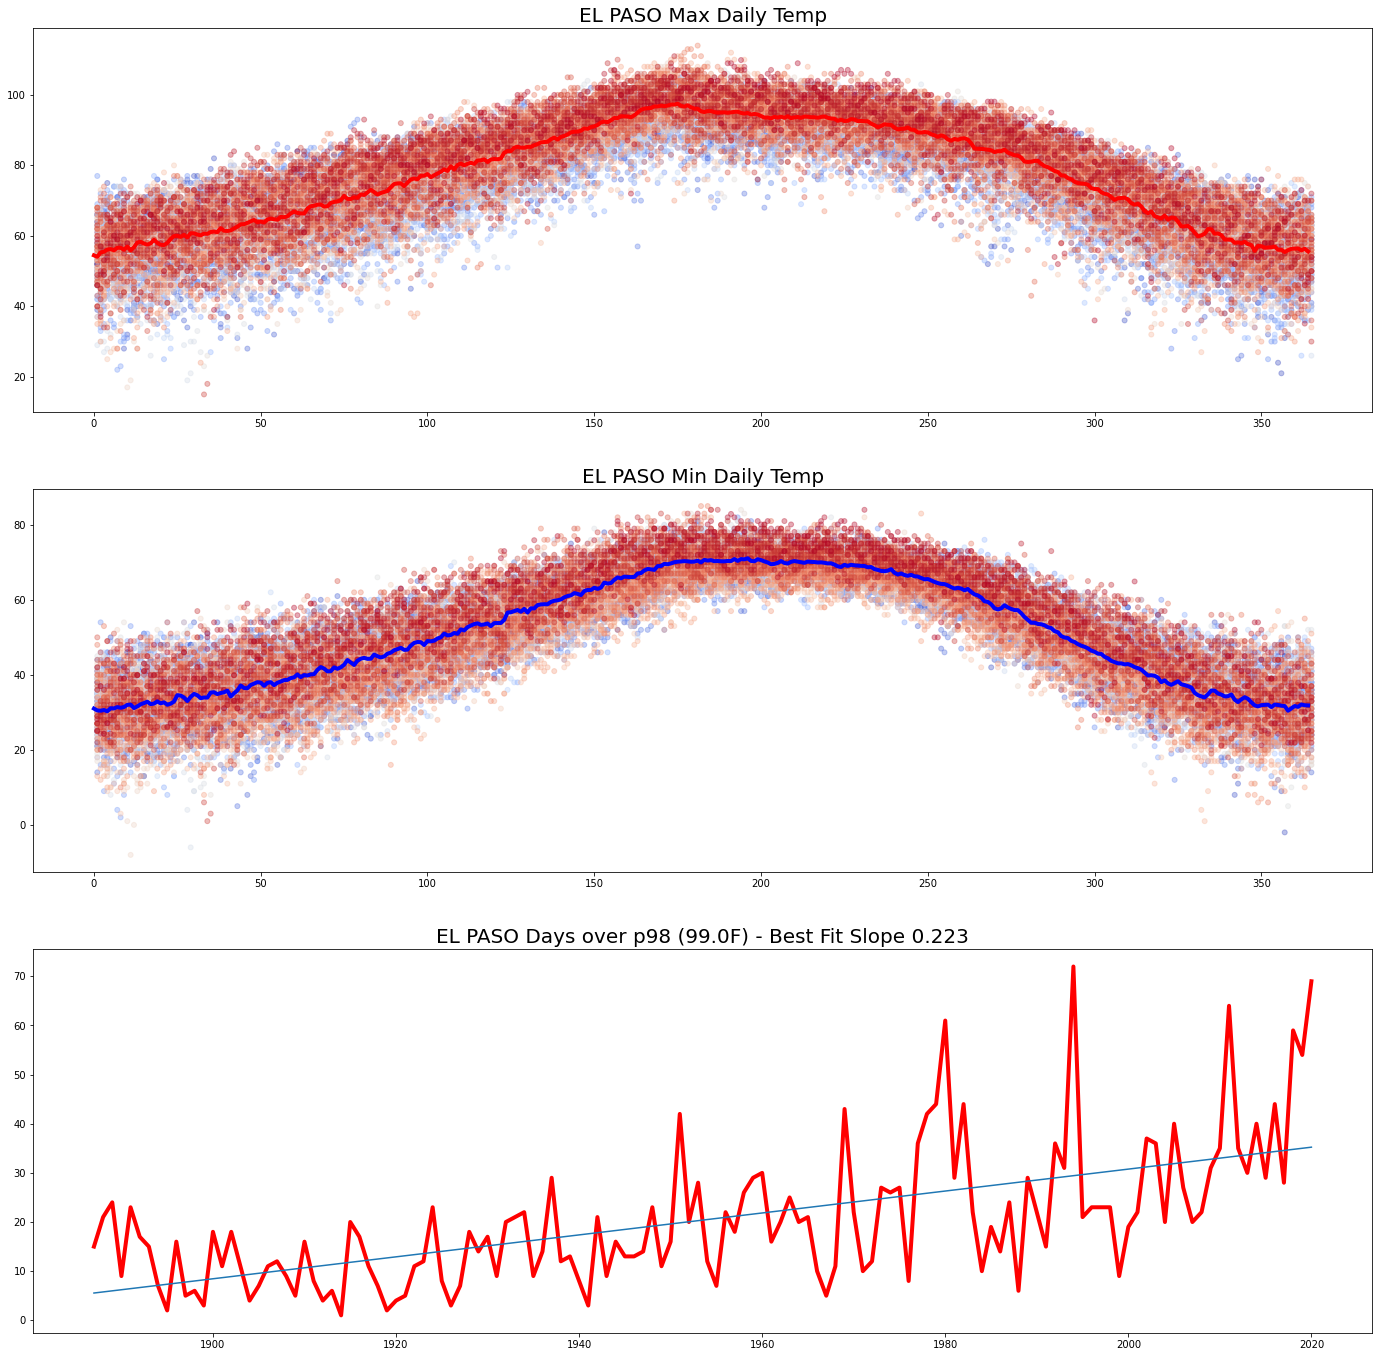

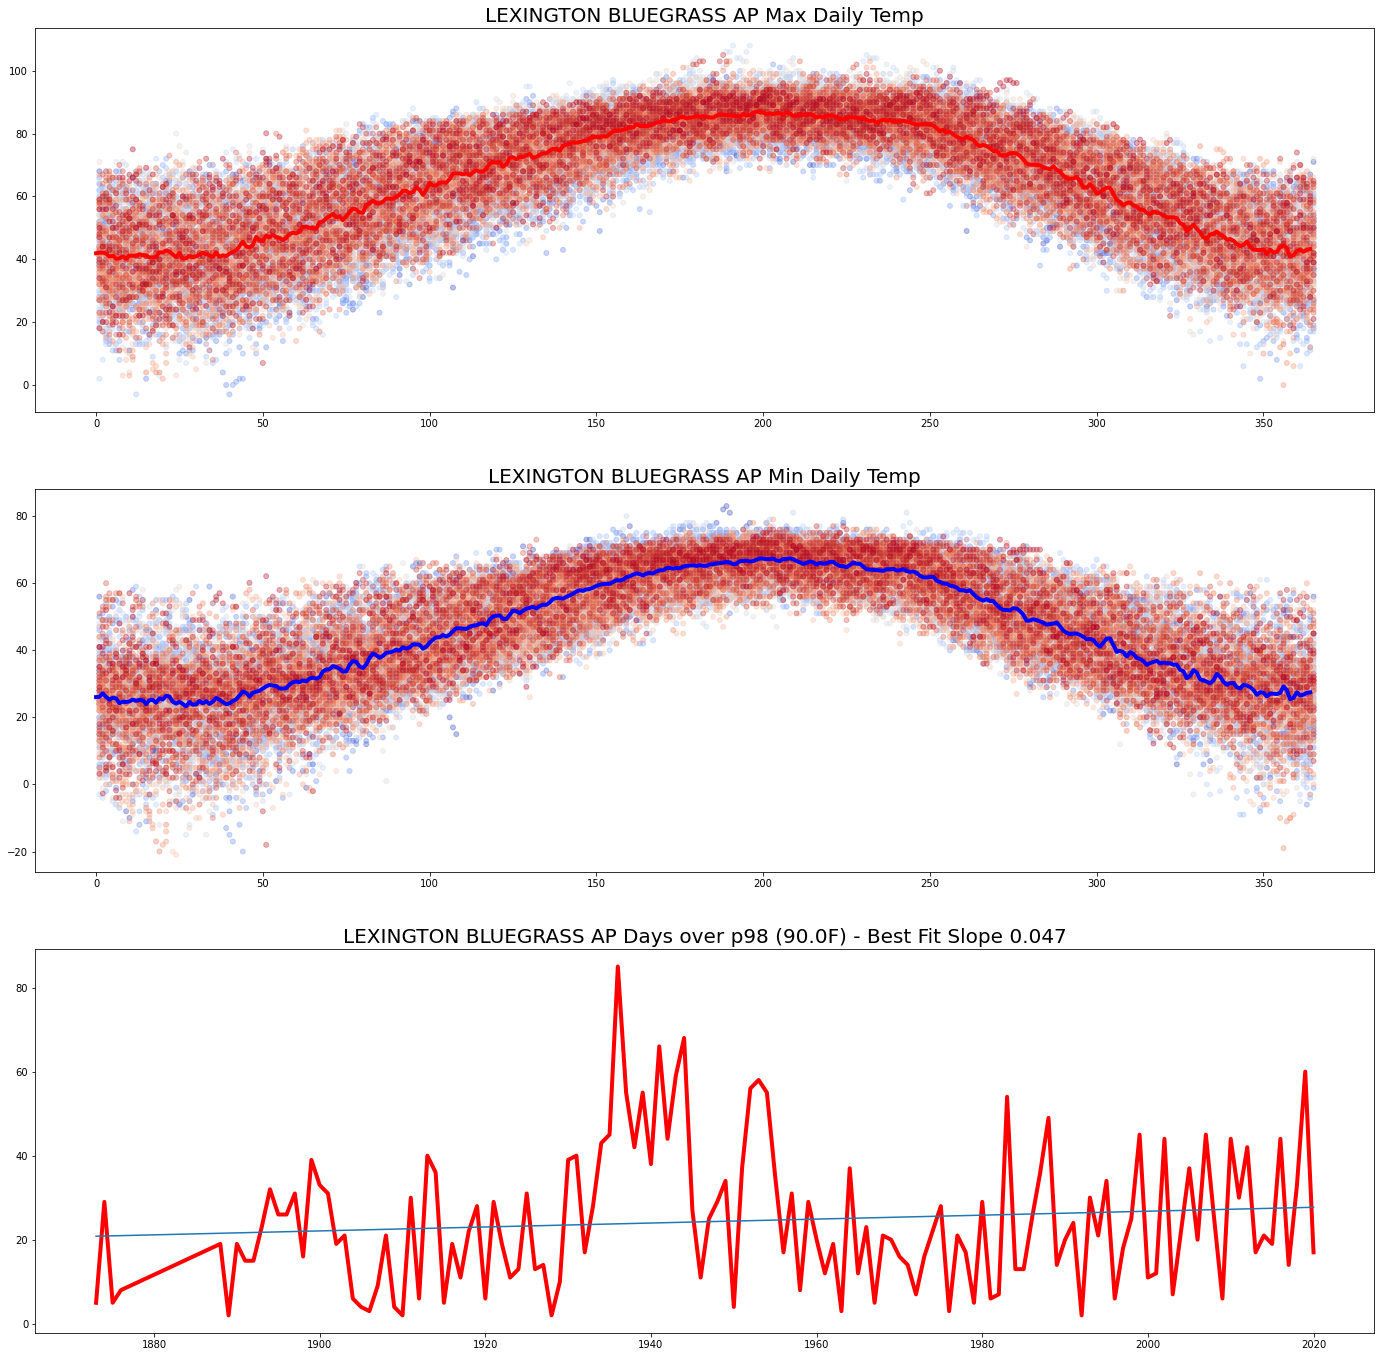

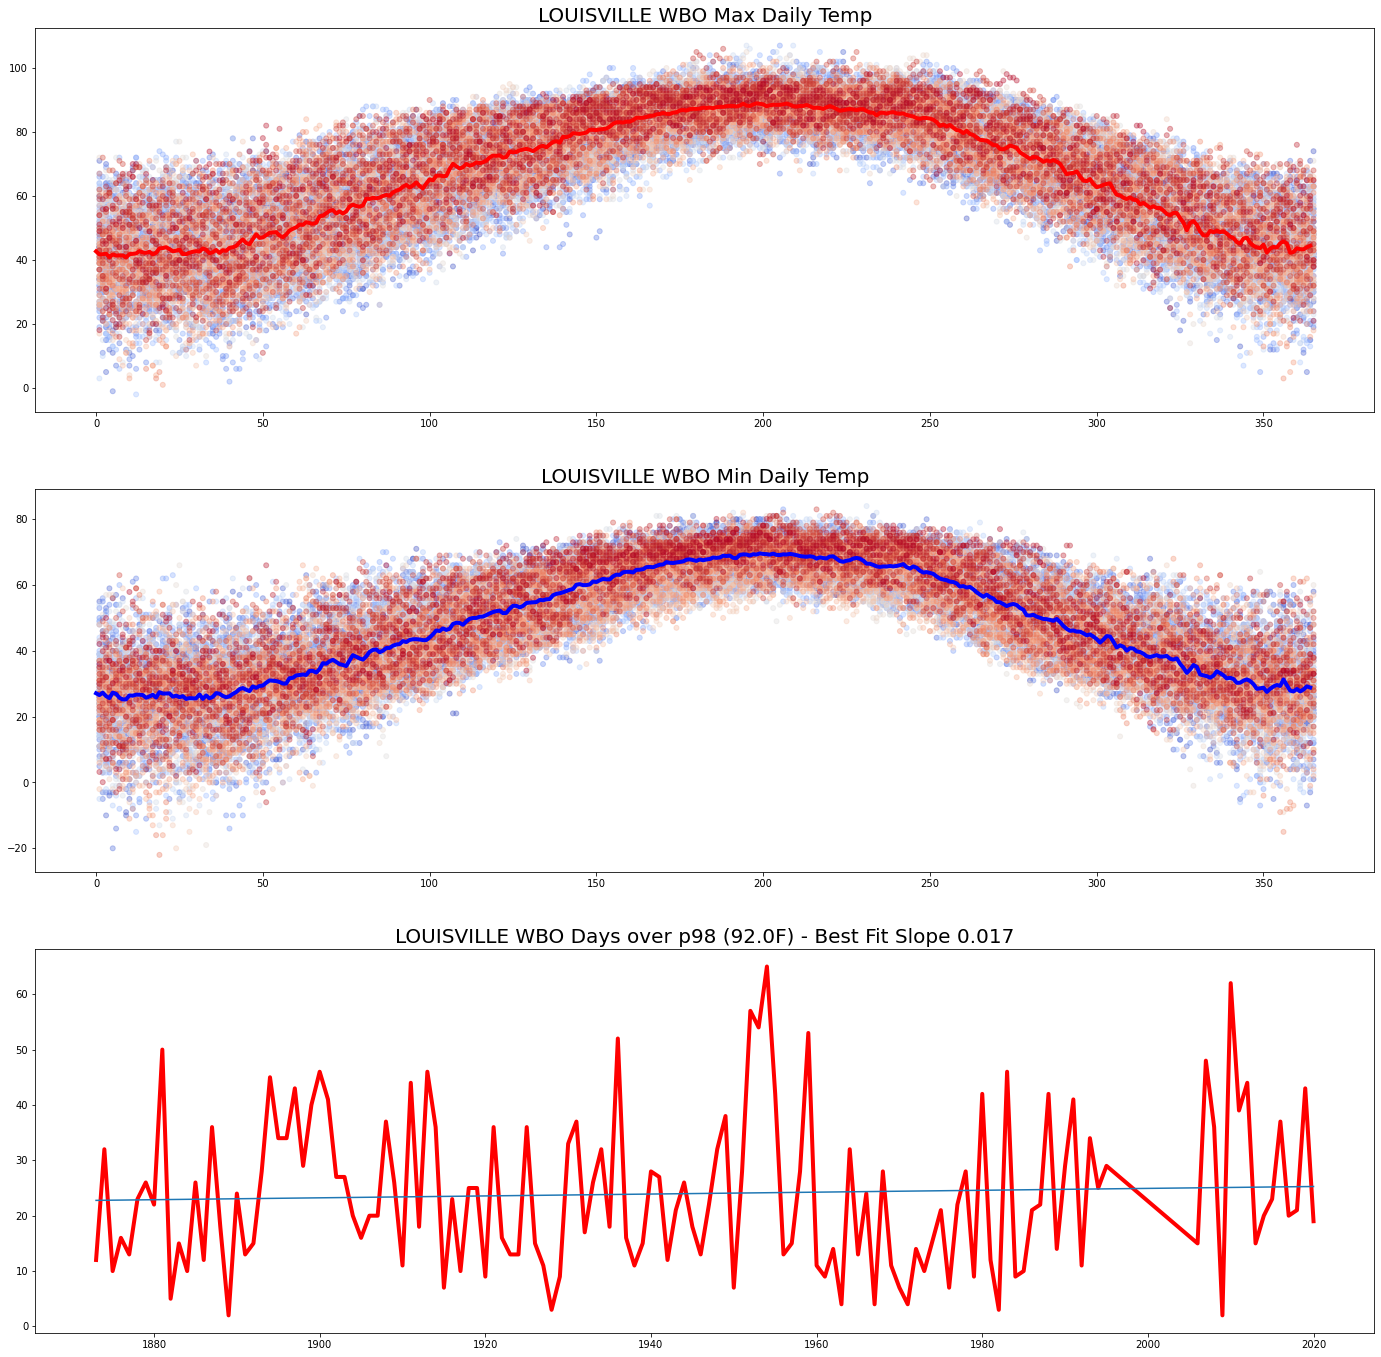

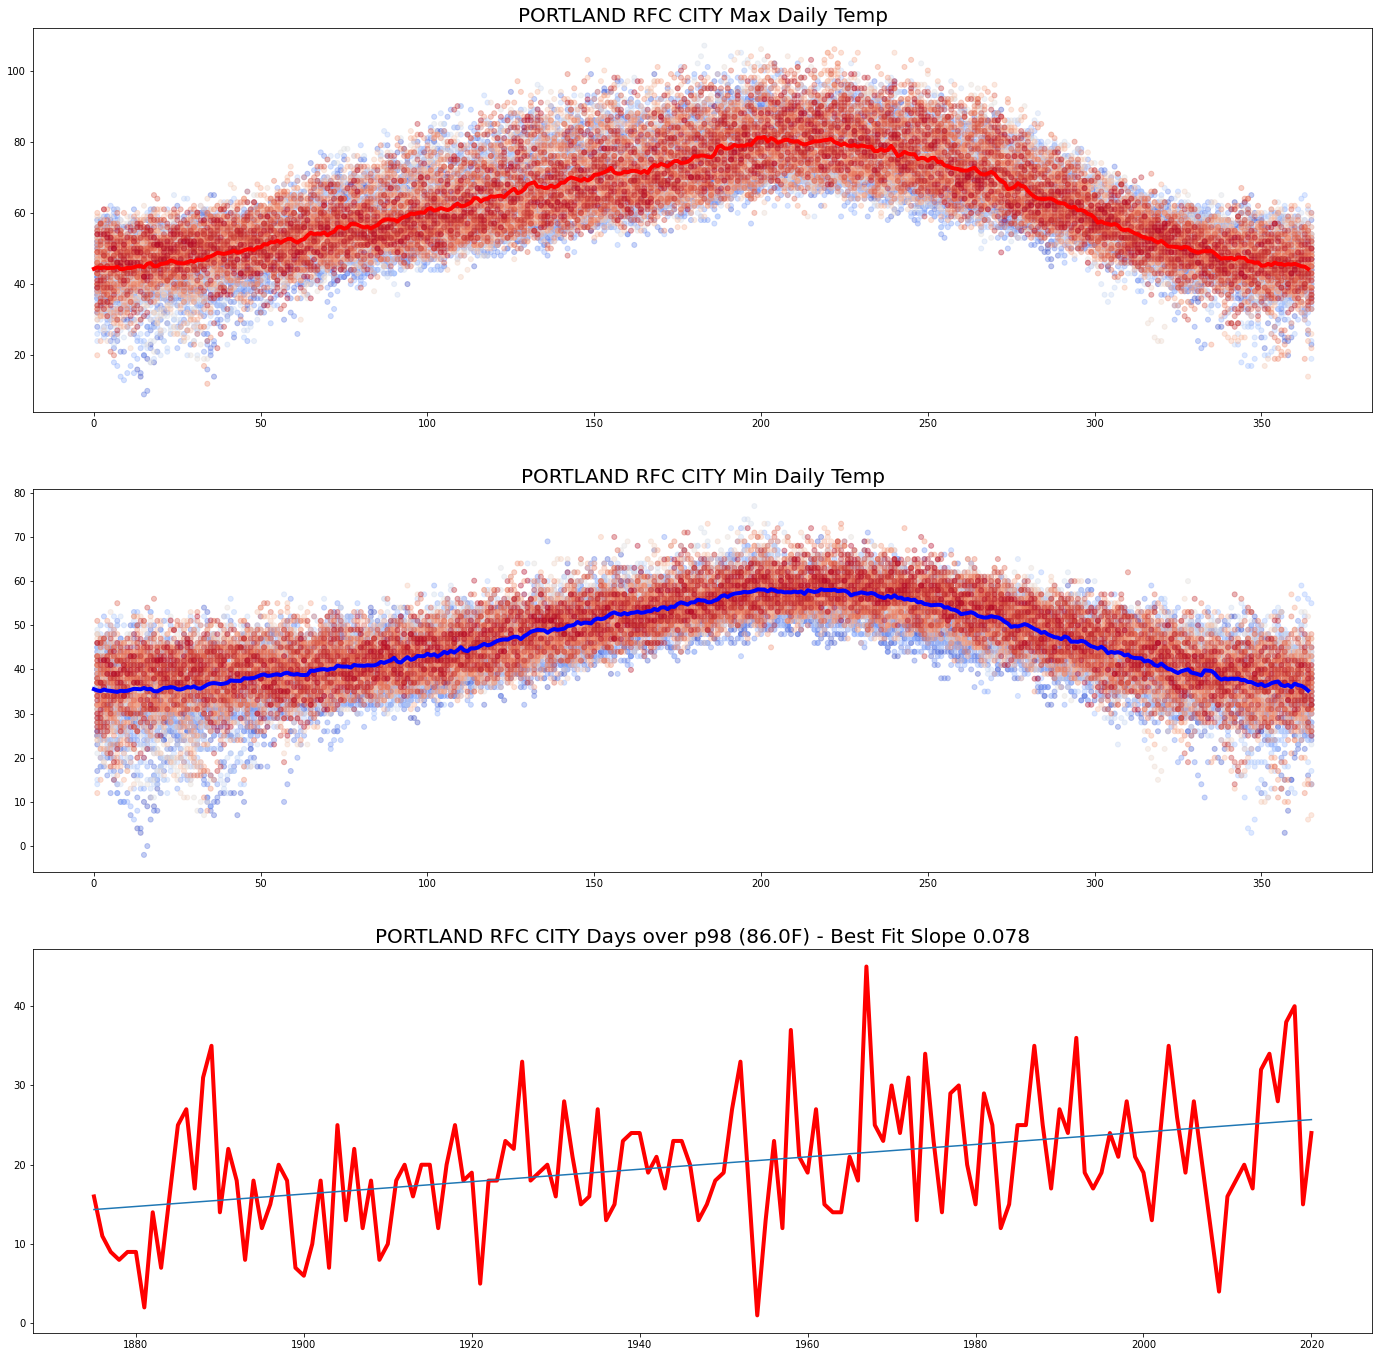

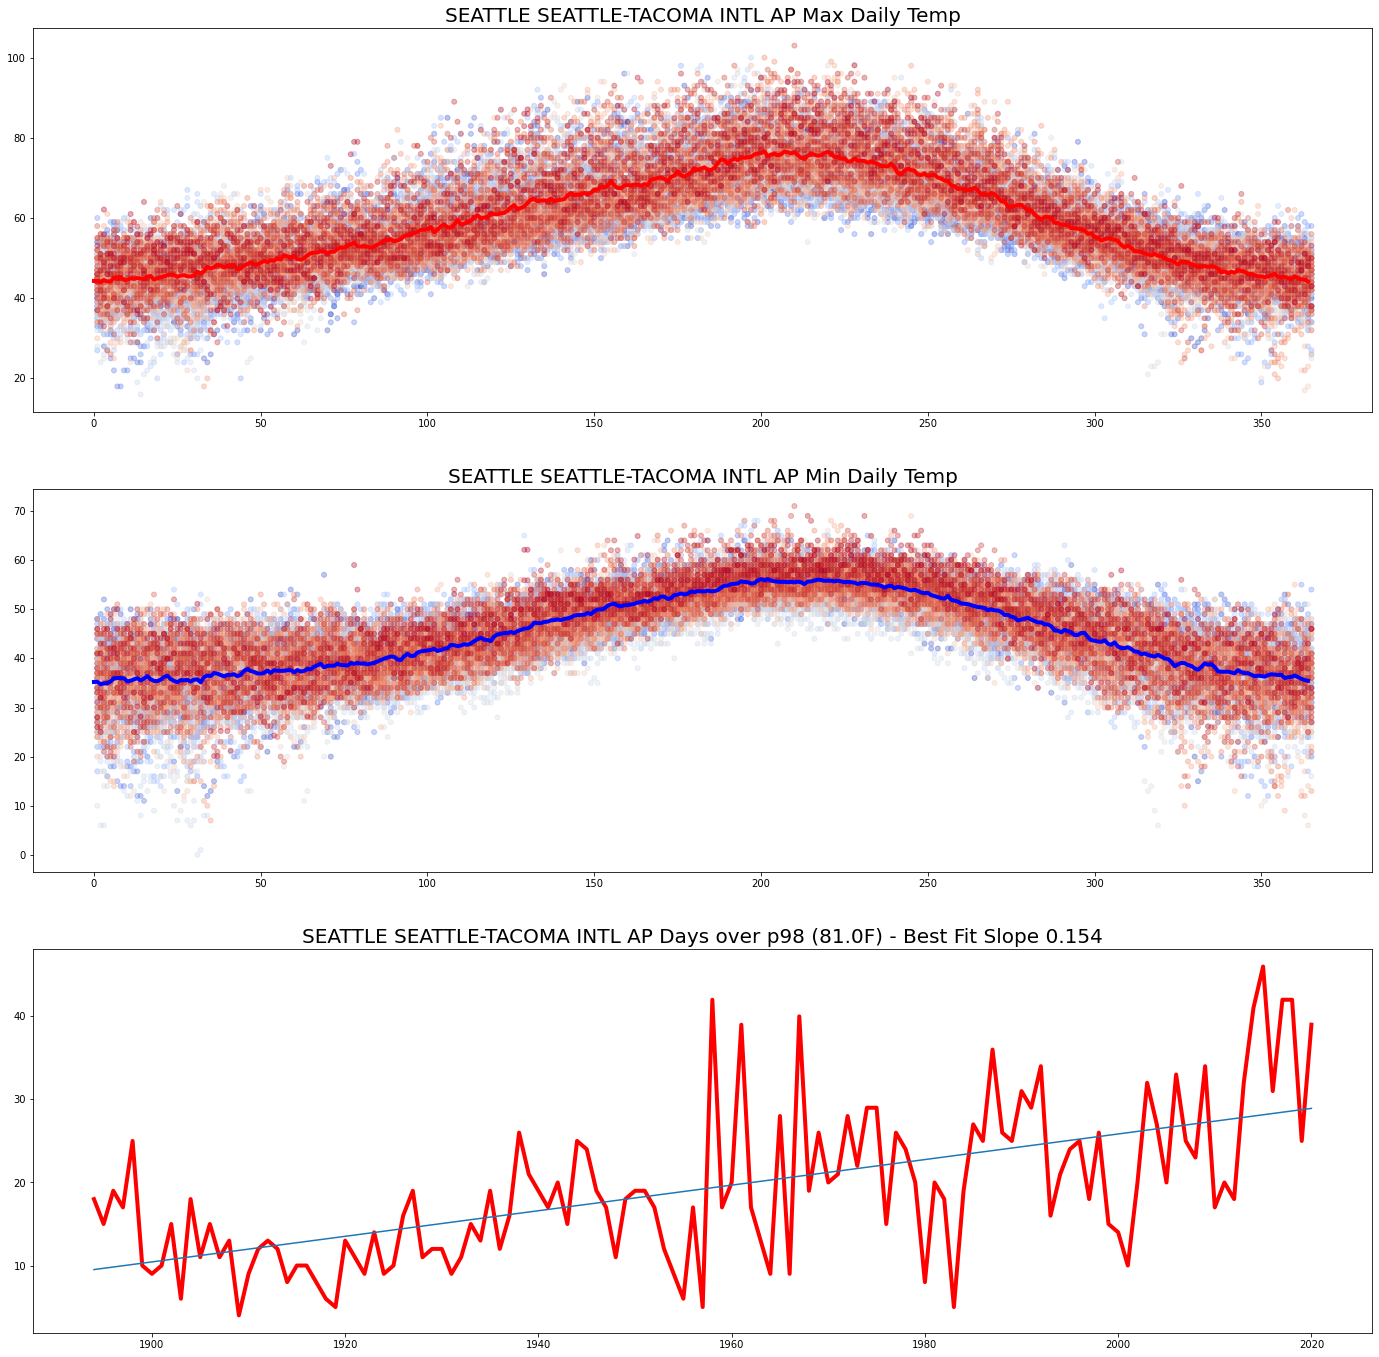

In [8]:
for city, data in city_data.items():
    fig, axs = plt.subplots(3)
    fig.set_figheight(24)
    fig.set_figwidth(24)

    axs[0].scatter(data['doy']['days'], data['doy']['tmaxs'], s=5**2, c=data['doy']['years'], cmap='coolwarm', alpha=.35)
    axs[0].plot(list(range(365)), data['doy']['doy_avg_tmax'], 'r', linewidth=4)
    axs[0].set_title(f'{city} Max Daily Temp', fontsize=20)

    axs[1].scatter(data['doy']['days'], data['doy']['tmins'], s=5**2, c=data['doy']['years'], cmap='coolwarm', alpha=.35)
    axs[1].plot(list(range(365)), data['doy']['doy_avg_tmin'], 'b', linewidth=4)
    axs[1].set_title(f'{city} Min Daily Temp', fontsize=20)
    
    years = list(data['hot_days'].keys())
    axs[2].plot(years, data['hot_days'].values(), 'r', linewidth=4)
    m, b = np.polyfit(years, list(data['hot_days'].values()), 1)
    x = np.arange(years[0], years[-1]+1, 1)    
    axs[2].plot(x, m*x + b)
    axs[2].set_title(f'{city} Days over p98 ({data["percentiles"]["p98"]}F) - Best Fit Slope {m:0.3f}', fontsize=20)

None